In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import pandas as pd

In [2]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_daily_SSA_processed.nc")
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 365, s_rho: 31, eta_rho: 600, xi_rho: 600)
Coordinates:
  * s_rho        (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
    x_rho        (eta_rho, xi_rho) float64 ...
    y_rho        (eta_rho, xi_rho) float64 ...
  * ocean_time   (ocean_time) datetime64[ns] 2025-12-28 ... 2026-12-27
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_rho      (eta_rho, xi_rho) float64 ...
    z_rho0       (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    zeta         (ocean_time, eta_rho, xi_rho) float32 ...
    eke          (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    dx           (eta_rho, xi_rho) float64 ...
Attributes: (12/36)
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    Conventions:                CF-1.4, SGRID-0.3
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    var_info:                   ROMS/External/varinfo.yaml
    ...                         ...
    tiling:                     024x020
    history:                    Mon Mar 18 23:37:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Mar 18 23:37:01 2024: Appended file ROMS_...

In [3]:
ds_grid=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_grid_vars.nc")
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut
grid = makeROMSGridObject(ds_grid)
del(ds_grid)

In [4]:
ds=ds.drop(['x_rho','y_rho'])
ds

<xarray.Dataset>
Dimensions:      (ocean_time: 365, s_rho: 31, eta_rho: 600, xi_rho: 600)
Coordinates:
  * s_rho        (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * ocean_time   (ocean_time) datetime64[ns] 2025-12-28 ... 2026-12-27
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_rho      (eta_rho, xi_rho) float64 ...
    z_rho0       (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    zeta         (ocean_time, eta_rho, xi_rho) float32 ...
    eke          (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    dx           (eta_rho, xi_rho) float64 ...
Attributes: (12/36)
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    Conventions:                CF-1.4, SGRID-0.3
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    var_info:                   ROMS/External/varinfo.yaml
    ...                         ...
    tiling:                     024x020
    history:                    Mon Mar 18 23:37:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Mar 18 23:37:01 2024: Appended file ROMS_...

In [5]:
import sys
import os
sys.path.append(os.path.abspath('/seq001/external/'))
from mySSA import mySSA
import pandas as pd

In [6]:
# make the time series
ts_in = ds.eke.isel(s_rho=-1,eta_rho=550,xi_rho=250).drop(['lon_rho','lat_rho','z_rho0','s_rho'])
# drop the non-used variables/coordinates
ts = ts_in.to_dataframe()
ssa = mySSA(ts)

In [7]:
K=12
ssa.embed(embedding_dimension=K,verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  12
Trajectory dimensions	: (12, 354)
Complete dimension	: (12, 354)
Missing dimension     	: (12, 0)


In [8]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 12
Dimension of projection space	: 12
Characteristic of projection	: 1.0


/seq001/external/mySSA.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


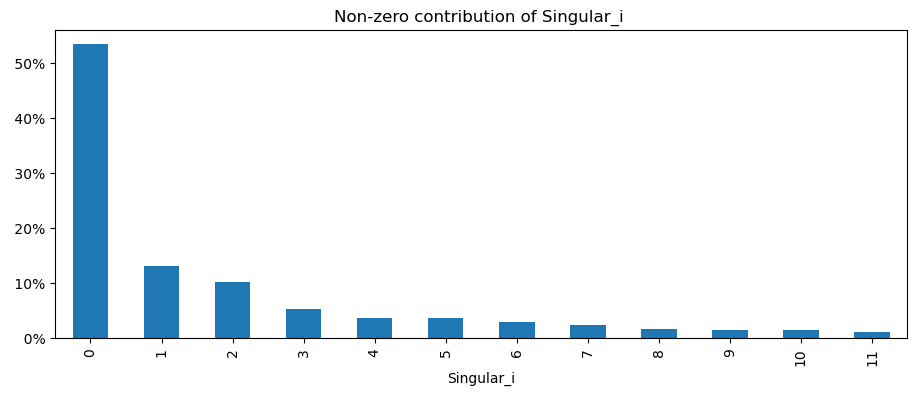

In [9]:
ssa.view_s_contributions()

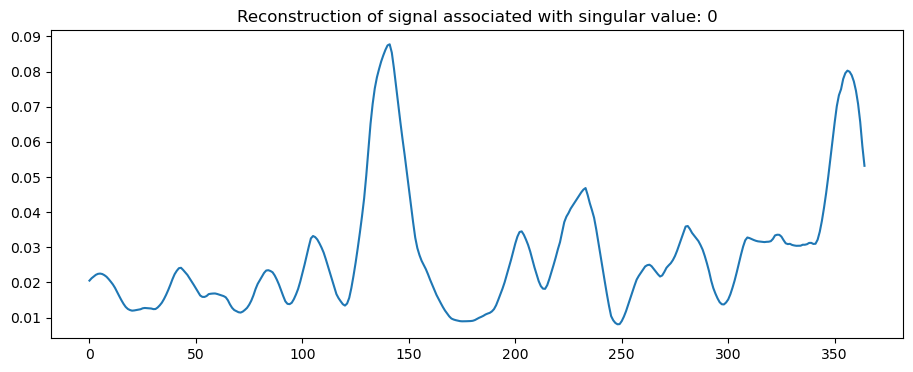

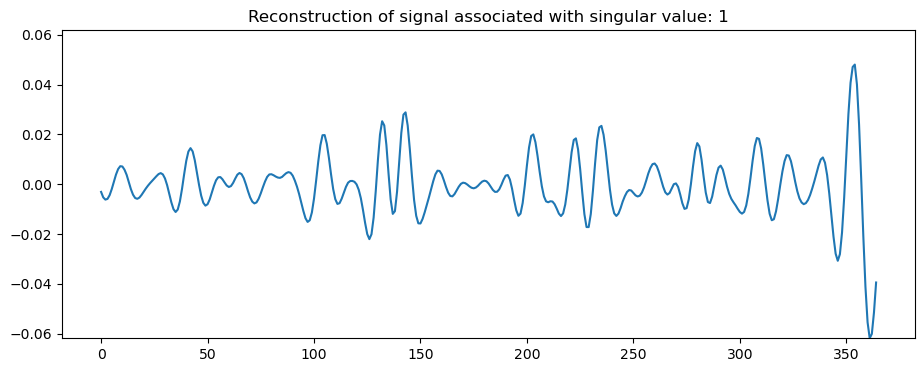

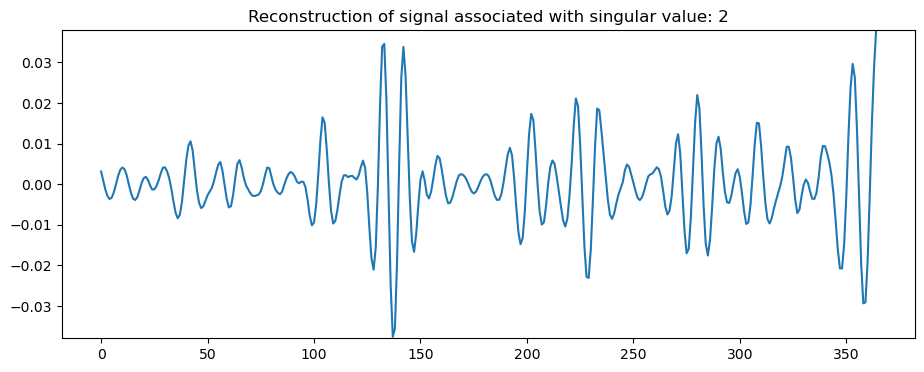

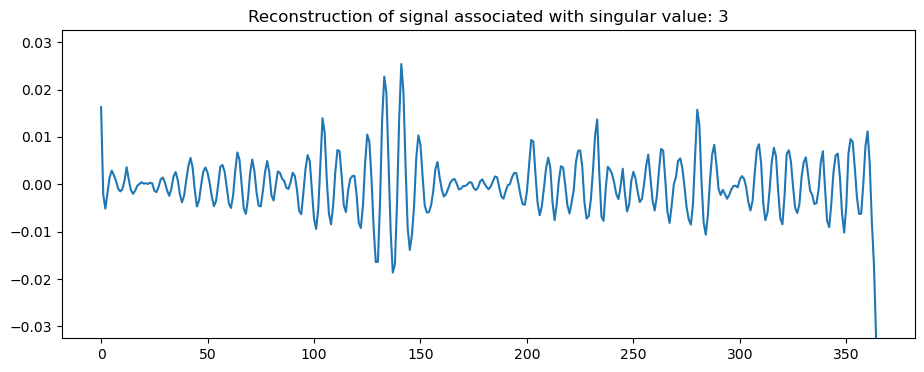

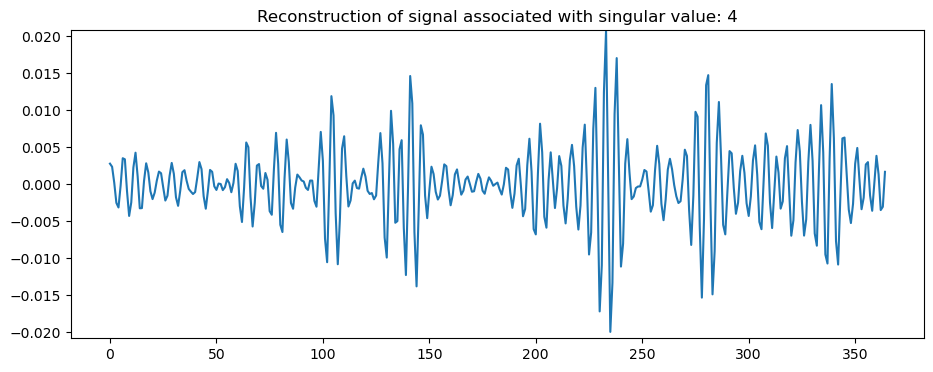

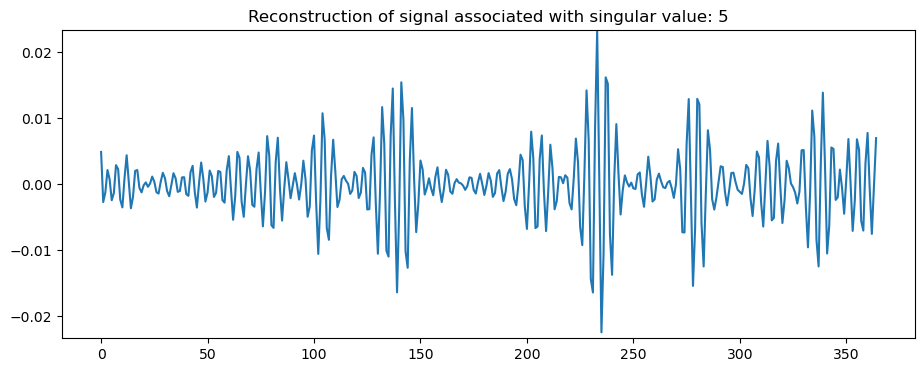

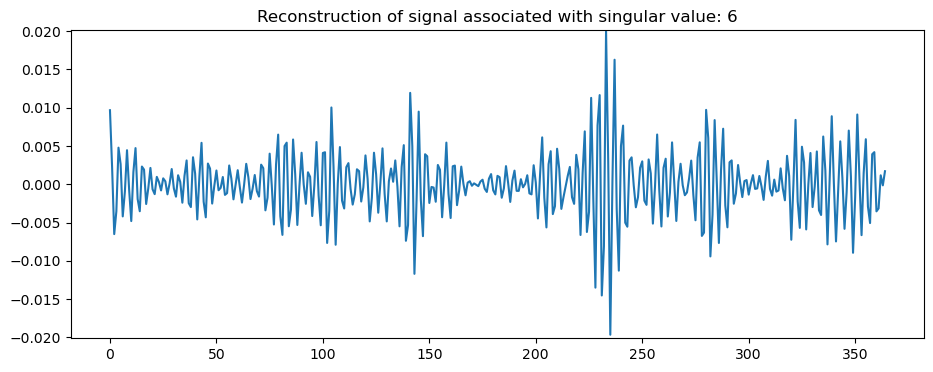

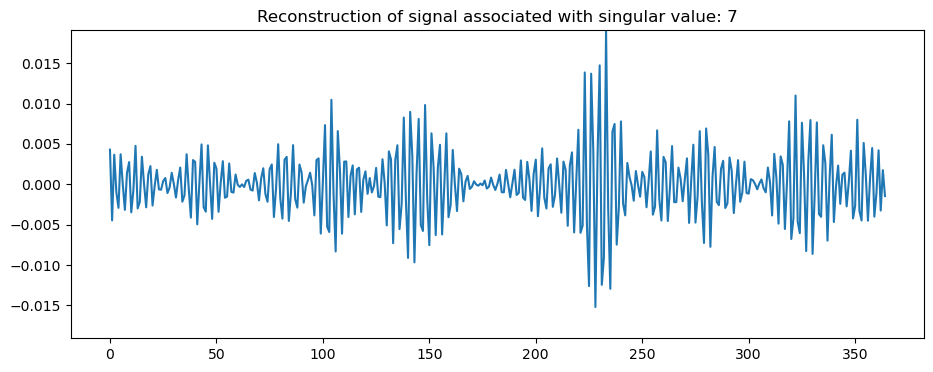

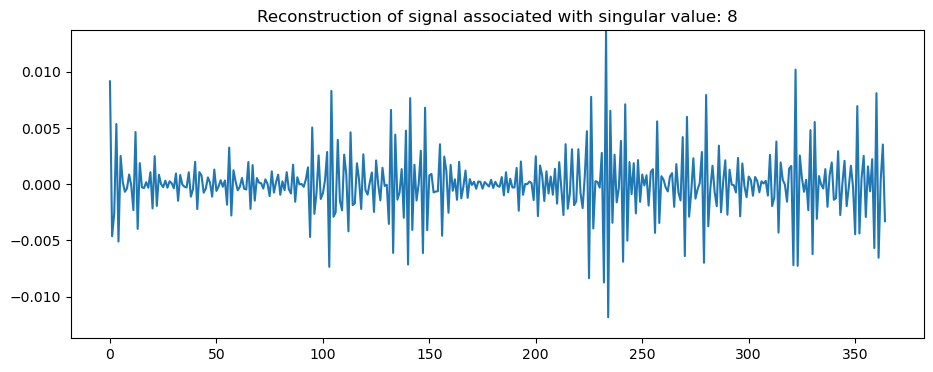

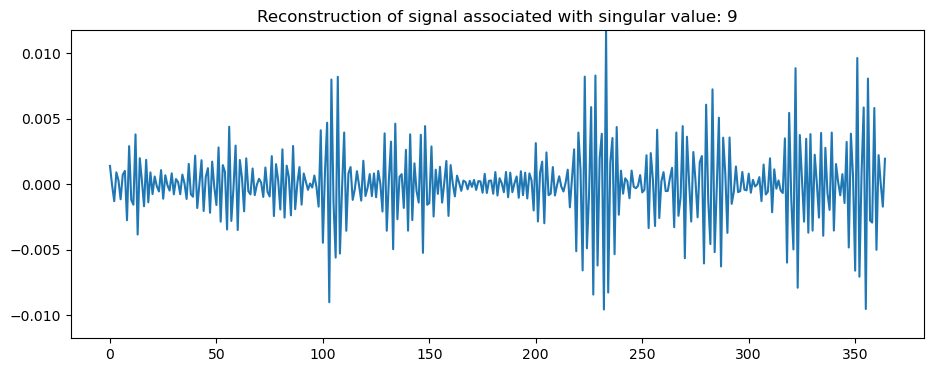

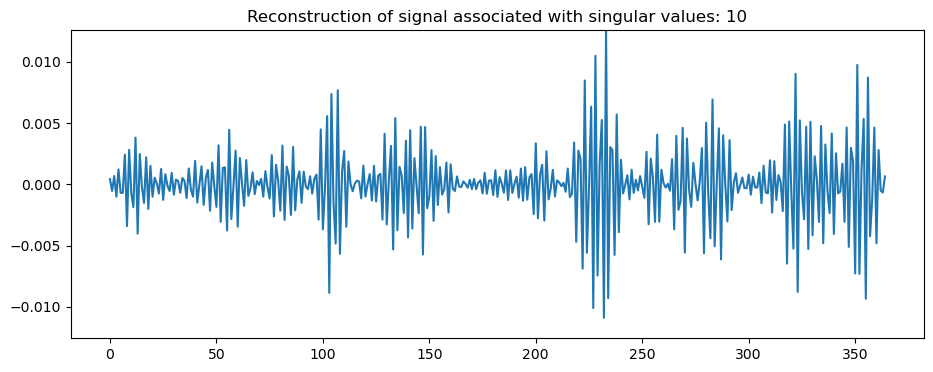

In [10]:
for i in range(11):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)

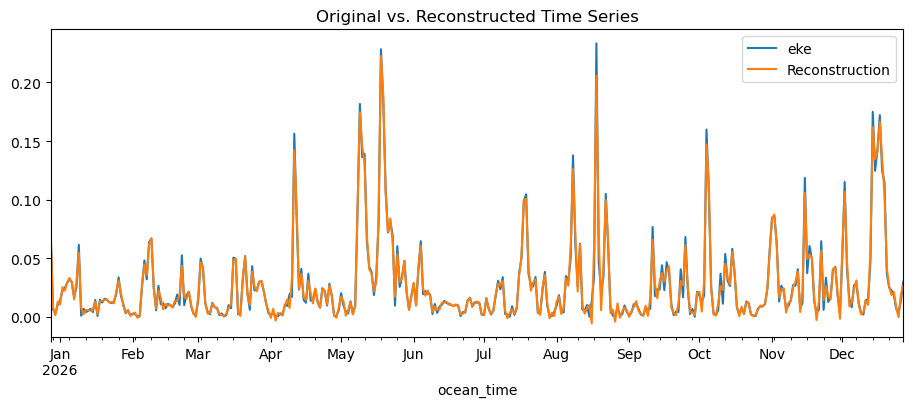

In [11]:
streams10 = [i for i in range(10)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10], 
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

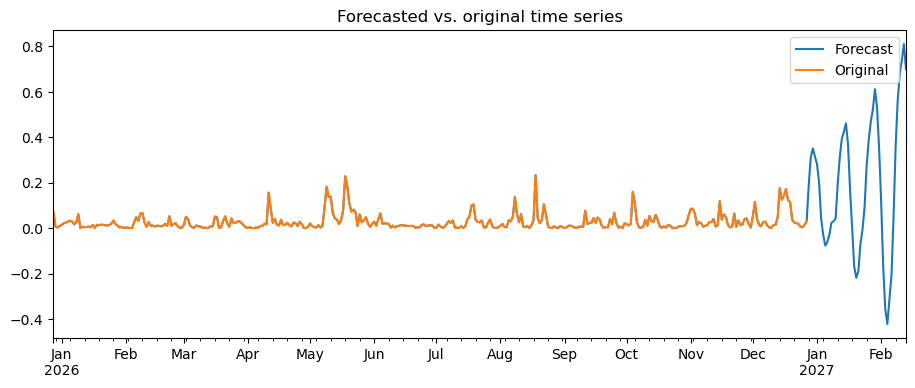

In [12]:
ssa.forecast_recurrent(steps_ahead=48, singular_values=streams10, plot=True)

Spatial Map

In [13]:
# Functions
from log_progress import log_progress
from mySSA import mySSA
import pandas as pd
from scipy import signal

def get_var_map(ts_map,K):
    
    var_map = np.tile(np.zeros_like(ts_map[0].values),(4,1,1))
    
    for j in log_progress(ts_map.eta_rho.values,name='eta'):
        for i in ts_map.xi_rho.values:
             var_map[:,j,i] = get_var(ts_map[:,j,i],K)

    return var_map

def get_var(ts_cell,K):
    # expects input as a xarray, then will convert to pandas dataframe
    # also make sure to remove any other coordinates/variables (except for time coordinate)
    
    if np.var(ts_cell.values) == 0.0:
        var_slow,var_fast,var_slow_contr,var_fast_contr = 0,0,0,0
        
    else:
        
        ts = ts_cell.copy()
        ts[:] = signal.detrend(ts_cell.values,-1,'linear')
        ssa = mySSA(ts.to_dataframe())

        ssa.embed(embedding_dimension=K)
        ssa.decompose()

        slow_rho_idx = np.argmax(np.abs(ssa.U.sum(0))/(np.abs(ssa.U).sum(0)))
        fast_rho_idx = np.delete(range(K),slow_rho_idx)

        var_slow,var_slow_contr = ssa.s[slow_rho_idx],ssa.s_contributions.values[slow_rho_idx][0]
        var_fast,var_fast_contr = sum(np.delete(ssa.s,slow_rho_idx)),sum(np.delete(ssa.s_contributions.values.squeeze(),slow_rho_idx))
    
    return var_slow,var_slow_contr,var_fast,var_fast_contr

In [18]:
input = ds.eke.isel(s_rho=-1)

input = input.fillna(0) # remove any nan values

mask = ~(input.isel(ocean_time=0)==0) # make mask now

input = input.drop(['lon_rho','lat_rho','z_rho0','s_rho'])

In [19]:
#input = input.drop(['lon_rho','lat_rho','z_rho0','s_rho']) #drop extra coords

eke_var_map_12 = get_var_map(input,7)


ds["eke_var_map_12_slow"] = (('eta_rho','xi_rho'),eke_var_map_12[1])
ds["eke_var_map_12_fast"] = (('eta_rho','xi_rho'),eke_var_map_12[3])

In [21]:
eke_var_map_12 = get_var_map(input,60)


ds["eke_var_map_60_slow"] = (('eta_rho','xi_rho'),eke_var_map_12[1])
ds["eke_var_map_60_fast"] = (('eta_rho','xi_rho'),eke_var_map_12[3])

Text(0.05, 0.03, '14.0-76.0%')

<Figure size 1100x400 with 0 Axes>

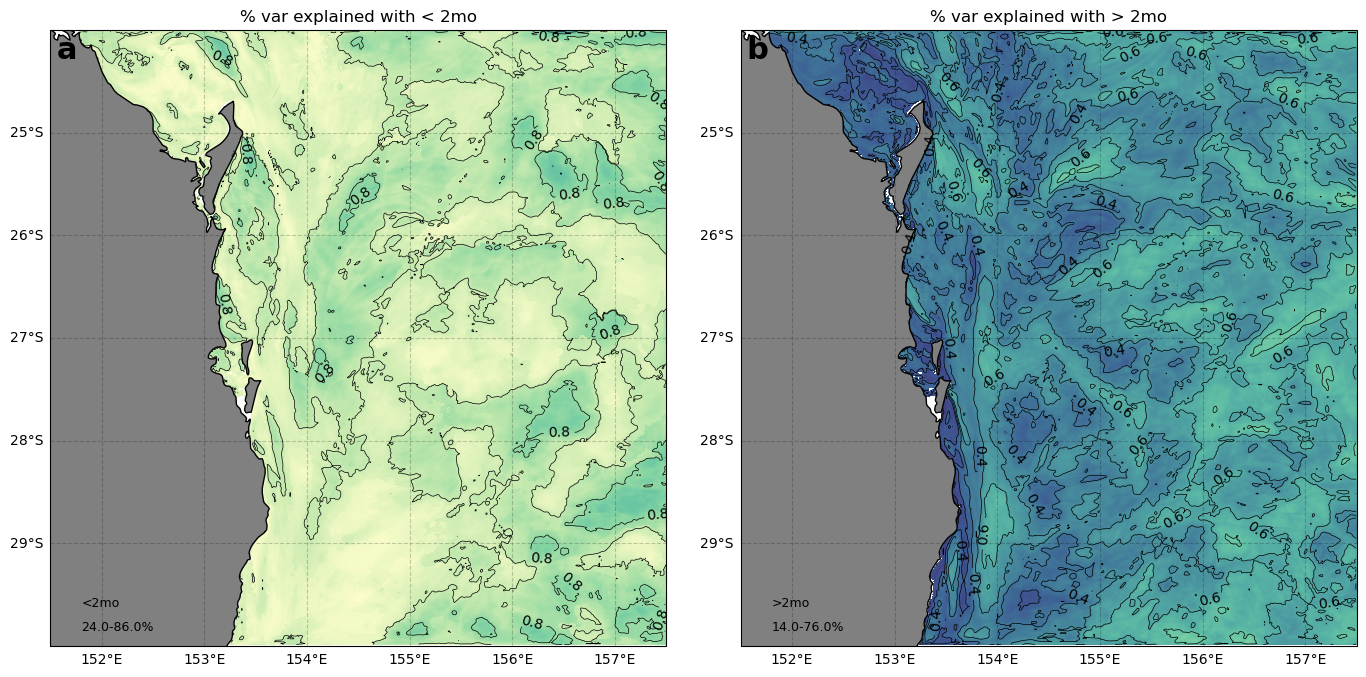

In [22]:
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[17,8])
ax = None
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke_var_map_60_fast.where(mask),vmin=0,vmax=1,cmap='cmo.deep_r')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke_var_map_60_fast.where(mask),colors='k',levels=np.arange(0,1.1,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,levels=np.arange(0,1.2,.2),inline=True)
ax.set_title('% var explained with < 2mo')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .07, '<2mo',fontsize=9, va='center', ha='left', transform=ax.transAxes)
ax.text(.05, .03,  str((ds.eke_var_map_12_fast.where(mask).min()*100).round().values)+'-'+str((ds.eke_var_map_12_fast.where(mask)*100).max().round().values)+'%',fontsize=9, va='center', ha='left', transform=ax.transAxes)

ax=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_slow.where(mask),vmin=0,vmax=1,cmap='cmo.deep_r')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_slow.where(mask),colors='k',levels=np.arange(0,1.1,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,levels=np.arange(0,1.2,.2),inline=True)
ax.set_title('% var explained with > 2mo')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .07, '>2mo',fontsize=9, va='center', ha='left', transform=ax.transAxes)
ax.text(.05, .03,  str((ds.eke_var_map_12_slow.where(mask).min()*100).round().values)+'-'+str((ds.eke_var_map_12_slow.where(mask)*100).max().round().values)+'%',fontsize=9, va='center', ha='left', transform=ax.transAxes)



#cbar = fig.colorbar(im)
#cbar.ax.set_ylabel('Fractional % explained')
#cbar.add_lines(co)

Text(0.05, 0.03, '0.0-42.0%')

<Figure size 1100x400 with 0 Axes>

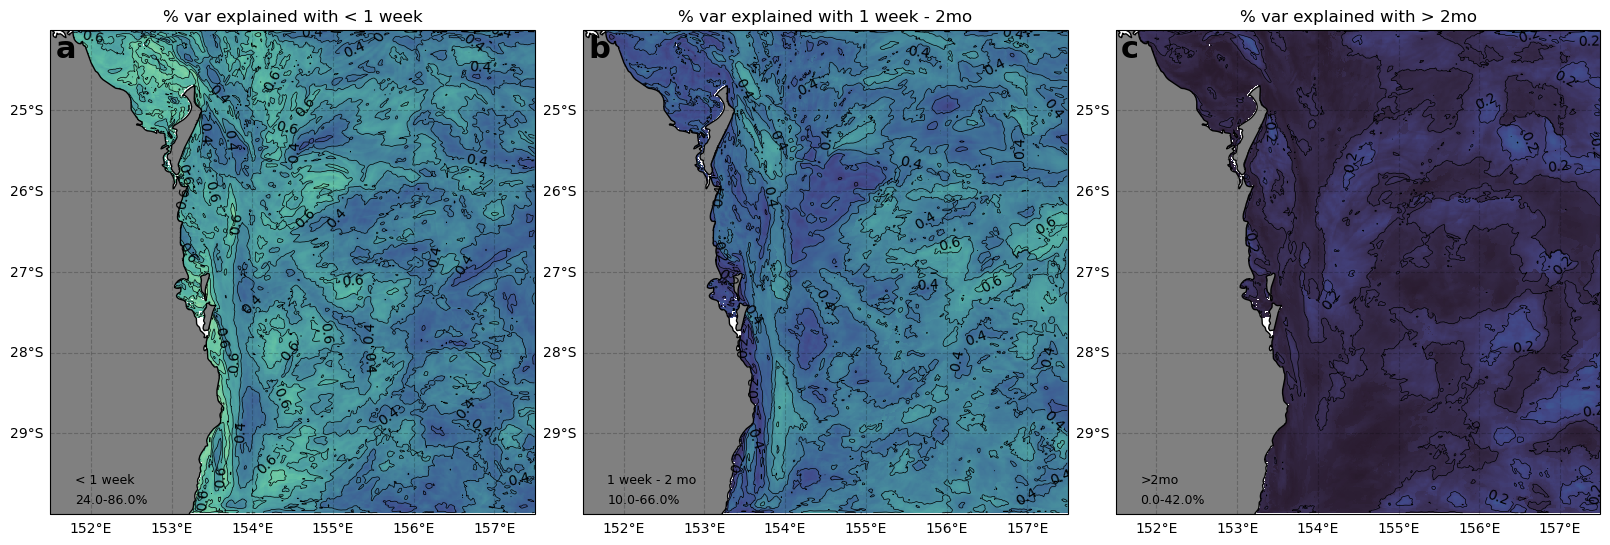

In [27]:
gs = gridspec.GridSpec(nrows=1,ncols=3,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_fast.where(mask),vmin=0,vmax=1,cmap='cmo.deep_r')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke_var_map_12_fast.where(mask),colors='k',levels=np.arange(0,1.1,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,levels=np.arange(0,1.2,.2),inline=True)
ax.set_title('% var explained with < 1 week')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .07, '< 1 week',fontsize=9, va='center', ha='left', transform=ax.transAxes)
ax.text(.05, .03,  str((ds.eke_var_map_12_fast.where(mask).min()*100).round().values)+'-'+str((ds.eke_var_map_12_fast.where(mask)*100).max().round().values)+'%',fontsize=9, va='center', ha='left', transform=ax.transAxes)

ax=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,(ds.eke_var_map_60_fast-ds.eke_var_map_12_fast).where(mask),vmin=0,vmax=1,cmap='cmo.deep_r')
co=ax.contour(ds.lon_rho,ds.lat_rho,(ds.eke_var_map_60_fast-ds.eke_var_map_12_fast).where(mask),colors='k',levels=np.arange(0,1.1,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,levels=np.arange(0,1.2,.2),inline=True)
ax.set_title('% var explained with 1 week - 2mo')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .07, '1 week - 2 mo',fontsize=9, va='center', ha='left', transform=ax.transAxes)
ax.text(.05, .03,  str(((ds.eke_var_map_60_fast-ds.eke_var_map_12_fast).where(mask).min()*100).round().values)+'-'+str(((ds.eke_var_map_60_fast-ds.eke_var_map_12_fast).where(mask)*100).max().round().values)+'%',fontsize=9, va='center', ha='left', transform=ax.transAxes)

ax=fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke_var_map_60_slow.where(mask),vmin=0,vmax=1,cmap='cmo.deep_r')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke_var_map_60_slow.where(mask),colors='k',levels=np.arange(0,1.1,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,levels=np.arange(0,1.2,.2),inline=True)
ax.set_title('% var explained with > 2mo')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .07, '>2mo',fontsize=9, va='center', ha='left', transform=ax.transAxes)
ax.text(.05, .03,  str((ds.eke_var_map_60_slow.where(mask).min()*100).round().values)+'-'+str((ds.eke_var_map_60_slow.where(mask)*100).max().round().values)+'%',fontsize=9, va='center', ha='left', transform=ax.transAxes)
